In [ ]:
!pip install kagglehub xgboost pandas scikit-learn matplotlib

In [ ]:
import os
import shutil

# إنشاء المجلد المطلوب
os.makedirs("/root/.kaggle", exist_ok=True)

# نسخ ملف kaggle.json إلى المسار الصحيح
shutil.copy("kaggle.json", "/root/.kaggle/kaggle.json")

# تغيير التصاريح لأمان الملف
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d gauravtopre/bank-customer-churn-dataset

Dataset URL: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset
License(s): other
  0% 0.00/187k [00:00<?, ?B/s]
100% 187k/187k [00:00<00:00, 366MB/s]


In [ ]:
!unzip bank-customer-churn-dataset.zip

Archive:  bank-customer-churn-dataset.zip
  inflating: Bank Customer Churn Prediction.csv  


In [ ]:
!pip install sdv pandas numpy scikit-learn matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/Bank Customer Churn Prediction.csv")  # Update with actual filename
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Print dataset shape (rows, columns)
print(f"Original Dataset Shape: {df.shape}")

Original Dataset Shape: (10000, 12)


In [ ]:
# Drop customer_id (not useful for ML)
df = df.drop(columns=["customer_id"])

from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder_country = LabelEncoder()
label_encoder_gender = LabelEncoder()

# Encode the "country" column (France = 0, Germany = 1, Spain = 2)
df["country"] = label_encoder_country.fit_transform(df["country"])

# Encode the "gender" column (Female = 0, Male = 1)
df["gender"] = label_encoder_gender.fit_transform(df["gender"])

# Separate features and target variable
X = df.drop(columns=["churn"])  # Features (independent variables)
y = df["churn"]  # Target (dependent variable)

# Split into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the first few rows after encoding
print("Updated Data Head (Training):")
print(X_train.head())


Updated Data Head (Training):
      credit_score  country  gender  age  tenure    balance  products_number  \
9254           686        0       1   32       6       0.00                2   
1561           632        1       1   42       4  119624.60                2   
1670           559        2       1   24       3  114739.92                1   
6087           561        0       0   27       9  135637.00                1   
6669           517        0       1   56       9  142147.32                1   

      credit_card  active_member  estimated_salary  
9254            1              1         179093.26  
1561            1              1         195978.86  
1670            1              0          85891.02  
6087            1              0         153080.40  
6669            0              0          39488.04  


In [ ]:
# Train Random Forest model on the original training data
clf_original = RandomForestClassifier(n_estimators=100, random_state=42)
clf_original.fit(X_train, y_train)

# Predict on test data
y_pred_original = clf_original.predict(X_test)

# Calculate accuracy
accuracy_original = accuracy_score(y_test, y_pred_original)

# Print performance
print(f"Original Data Random Forest Accuracy: {accuracy_original:.4f}")

Original Data Random Forest Accuracy: 0.8645


In [ ]:
!pip install sdv torch torchvision torchaudio

**TVAE**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, data_dim, compress_dims, embedding_dim):
        super(Encoder, self).__init__()
        layers = []
        dim = data_dim
        for item in compress_dims:
            layers.append(nn.Linear(dim, item))
            layers.append(nn.ReLU())
            dim = item
        self.seq = nn.Sequential(*layers)
        self.fc1 = nn.Linear(dim, embedding_dim)
        self.fc2 = nn.Linear(dim, embedding_dim)

    def forward(self, x):
        x = self.seq(x)
        mu = self.fc1(x)
        logvar = self.fc2(x)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        layers = []
        dim = embedding_dim
        for item in decompress_dims:
            layers.append(nn.Linear(dim, item))
            layers.append(nn.ReLU())
            dim = item
        layers.append(nn.Linear(dim, data_dim))
        self.seq = nn.Sequential(*layers)
        self.sigma = nn.Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, x):
        return self.seq(x), self.sigma

# Define TVAE Model
class TVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16, compress_dims=[256, 128], decompress_dims=[128, 256]):
        super(TVAE, self).__init__()
        self.encoder = Encoder(input_dim, compress_dims, latent_dim)
        self.decoder = Decoder(latent_dim, decompress_dims, input_dim)

    def forward(self, x):
        mu, std, logvar = self.encoder(x)
        eps = torch.randn_like(std)
        z = eps * std + mu  # Reparameterization trick
        recon_x, sigmas = self.decoder(z)
        return recon_x, sigmas, mu, logvar


**Training**

In [ ]:
# Load and preprocess dataset
df = pd.read_csv("/content/Bank Customer Churn Prediction.csv")
df = df.drop(columns=["customer_id"])  # Drop unnecessary column

# Convert categorical features into numbers
df["country"] = df["country"].astype("category").cat.codes
df["gender"] = df["gender"].astype("category").cat.codes

# Normalize numerical columns
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)

# Split into features (X) and target (y)
X = df.drop(columns=["churn"]).values
y = df["churn"].values

# Convert to PyTorch tensors
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Define Training Parameters
input_dim = X_train.shape[1]
latent_dim = 16
batch_size = 512  # Larger batch size for better stability
epochs = 500  # Increased epochs for better learning
lr = 0.0005  # Adjusted LR to improve convergence

# Initialize Model and Optimizer
model = TVAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Reduced weight decay

# Define Loss Function (Optimized for Stability)
def loss_function(recon_x, x, sigmas, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + 0.1 * kl_div  # Adjusted KL loss weight for better training

# Train TVAE
dataloader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch[0]
        optimizer.zero_grad()
        recon_x, sigmas, mu, logvar = model(batch)
        loss = loss_function(recon_x, batch, sigmas, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {total_loss:.4f}")

print("✅ TVAE Model Trained Successfully!")

Epoch 0/500, Loss: 3.4001
Epoch 50/500, Loss: 1.9312
Epoch 100/500, Loss: 1.9247
Epoch 150/500, Loss: 1.9245
Epoch 200/500, Loss: 1.9226
Epoch 250/500, Loss: 1.9240
Epoch 300/500, Loss: 1.9235
Epoch 350/500, Loss: 1.9215
Epoch 400/500, Loss: 1.9215
Epoch 450/500, Loss: 1.9216
✅ TVAE Model Trained Successfully!


In [ ]:
with torch.no_grad():
    z = torch.normal(mean=0, std=0.7, size=(20000, latent_dim))
    synthetic_data = model.decoder(z)[0].numpy()

synthetic_df = pd.DataFrame(synthetic_data, columns=df.drop(columns=["churn"]).columns)

# Reverse normalization
temp_synthetic_df = np.zeros((synthetic_df.shape[0], len(df.columns)))
temp_synthetic_df[:, :-1] = synthetic_df
temp_synthetic_df = scaler.inverse_transform(temp_synthetic_df)
synthetic_df = pd.DataFrame(temp_synthetic_df[:, :-1], columns=df.drop(columns=["churn"]).columns)

# Assign churn and clip categorical
synthetic_df["churn"] = np.random.choice([0, 1], size=20000)
synthetic_df["country"] = synthetic_df["country"].round().astype(int).clip(0, 2)
synthetic_df["gender"] = synthetic_df["gender"].round().astype(int).clip(0, 1)
synthetic_df["credit_card"] = synthetic_df["credit_card"].round().astype(int).clip(0, 1)
synthetic_df["active_member"] = synthetic_df["active_member"].round().astype(int).clip(0, 1)
synthetic_df["products_number"] = synthetic_df["products_number"].round().astype(int).clip(1, 3)

In [ ]:
# Round integer-like columns to match original discrete values
synthetic_df["credit_score"] = synthetic_df["credit_score"].round().astype(int)
synthetic_df["age"] = synthetic_df["age"].round().astype(int)
synthetic_df["tenure"] = synthetic_df["tenure"].round().astype(int)
synthetic_df["estimated_salary"] = synthetic_df["estimated_salary"].round(2)
synthetic_df["products_number"] = synthetic_df["products_number"].round().astype(int).clip(1, 3)

# Optional balance cleanup
synthetic_df["balance"] = synthetic_df["balance"].clip(lower=0)

# Preview result
print(synthetic_df.head())

   credit_score  country  gender  age  tenure       balance  products_number  \
0           651        1       1   39       5  76749.443470                2   
1           650        1       1   39       5  77104.669735                2   
2           654        1       1   39       5  77765.009095                2   
3           647        1       1   39       5  76162.045619                2   
4           647        1       1   38       5  76365.040602                2   

   credit_card  active_member  estimated_salary  churn  
0            1              1          99541.25      1  
1            1              1          99671.09      1  
2            1              1         101256.35      0  
3            1              1          98477.48      1  
4            1              1          98997.65      0  


**Testing generated data**

In [ ]:
print(f"Synthetic Dataset Shape: {synthetic_df.shape}")

Synthetic Dataset Shape: (20000, 11)


In [ ]:
synthetic_df["churn"] = clf_original.predict(synthetic_df.drop(columns=["churn"], errors='ignore'))

In [ ]:
# Train on synthetic data
clf_synthetic = RandomForestClassifier(n_estimators=100, random_state=42)
clf_synthetic.fit(X_synthetic, y_synthetic)

# Test on original real data
real_test_pred = clf_synthetic.predict(X_test)
cross_accuracy = accuracy_score(y_test, real_test_pred)

print(f"Train on Synthetic → Test on Real Accuracy: {cross_accuracy:.4f}")

Train on Synthetic → Test on Real Accuracy: 0.8035


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


**Comparison**

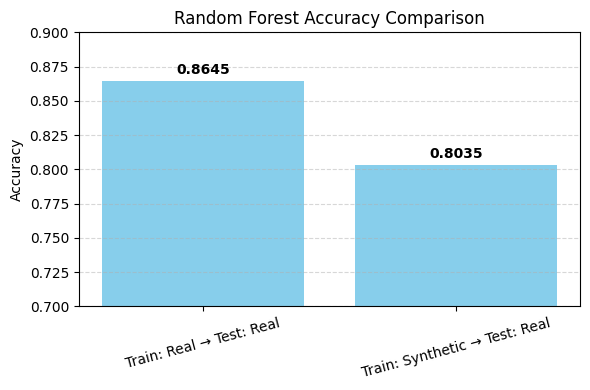

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Make sure df and synthetic_df are already defined!
# df = pd.read_csv("Churn_Modelling.csv")  ← if not yet done

# 1. Accuracy Comparison
# Already calculated in your previous steps
accuracies_filtered = {
    "Train: Real → Test: Real": 0.8645,
    "Train: Synthetic → Test: Real": 0.8035,
}

# Bar plot
plt.figure(figsize=(6, 4))
plt.bar(accuracies_filtered.keys(), accuracies_filtered.values(), color='skyblue')
plt.ylim(0.7, 0.9)
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy Comparison")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for i, (label, value) in enumerate(accuracies_filtered.items()):
    plt.text(i, value + 0.005, f"{value:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**installing data**

In [ ]:
synthetic_df.to_csv("synthetic_churn_data.csv", index=False)

In [ ]:
from google.colab import files
files.download("synthetic_churn_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>